#verify pyEMU results with the henry problem

In [1]:
%pylab inline
import os
import numpy as np
import pylab as ply
import pyemu
import pst_handler as phand
import mat_handler as mhand

Populating the interactive namespace from numpy and matplotlib


instaniate ```pyemu``` object and drop prior info.  Then reorder the jacobian and save as binary.  This is needed because the pest utilities require strict order between the control file and jacobian

In [2]:
la = pyemu.schur("pest.jco",verbose=False)
la.drop_prior_information()
jco_ord = la.jco.get(la.pst.obs_names,la.pst.par_names)
ord_base = "pest_ord"
jco_ord.to_binary(ord_base + ".jco")  

extract and save the forecast sensitivity vectors

In [3]:
pv_names = []
predictions =  ["pd_ten", "c_obs10_2"]
for pred in predictions:
    pv = jco_ord.extract(pred).T
    pv_name = pred + ".vec"
    pv.to_ascii(pv_name)
    pv_names.append(pv_name)
    

save the prior parameter covariance matrix as an uncertainty file

In [4]:
prior_uncfile = "pest.unc"
la.parcov.to_uncfile(prior_uncfile,covmat_file=None)

#PRECUNC7
write a response file to feed ```stdin``` to ```predunc7```

In [5]:
post_mat = "post.cov"
post_unc = "post.unc"
args = [ord_base + ".pst","1.0",prior_uncfile,
        post_mat,post_unc,"1"]
pd7_in = "predunc7.in"
f = open(pd7_in,'w')
f.write('\n'.join(args)+'\n')
f.close()
out = "pd7.out"
pd7 = os.path.join("exe","i64predunc7.exe")
os.system(pd7 + " <" + pd7_in + " >"+out)
for line in open(out).readlines():
    print line,


 PREDUNC7 Version 13.3. Watermark Numerical Computing.

 Enter name of PEST control file:  Enter observation reference variance: 
 Enter name of prior parameter uncertainty file: 
 Enter name for posterior parameter covariance matrix file:  Enter name for posterior parameter uncertainty file: 
 Use which version of linear predictive uncertainty equation:-
     if version optimized for small number of parameters   - enter 1
     if version optimized for small number of observations - enter 2
 Enter your choice: 
 - reading PEST control file pest_ord.pst....
 - file pest_ord.pst read ok.

 - reading Jacobian matrix file pest_ord.jco....
 - file pest_ord.jco read ok.

 - reading parameter uncertainty file pest.unc....
 - parameter uncertainty file pest.unc read ok.
 - forming XtC-1(e)X matrix....
 - inverting prior C(p) matrix....
 - inverting [XtC-1(e)X + C-1(p)] matrix....
 - writing file post.cov...
 - file post.cov written ok.
 - writing file post.unc...
 - file post.unc written ok.


load the posterior matrix written by ```predunc7```

In [6]:
post_pd7 = mhand.cov()
post_pd7.from_ascii(post_mat)

la_ord = pyemu.schur(jco="pest_ord.jco",predictions=predictions)
post_pyemu = la_ord.posterior_parameter
#post_pyemu = post_pyemu.get(post_pd7.row_names)

The cumulative difference between the two posterior matrices:

In [7]:
delta = (post_pd7 - post_pyemu).x
(post_pd7 - post_pyemu).to_ascii("delta.cov")
print delta.sum()
print delta.max(),delta.min()

1.70407837082e-06
4.97750649586e-08 -4.98772445567e-08


#PREDUNC1
write a response file to feed ```stdin```.  Then run ```predunc1``` for each forecast

In [8]:
args = [ord_base + ".pst", "1.0", prior_uncfile, None, "1"]
pd1_in = "predunc1.in"
pd1 = os.path.join("exe", "i64predunc1.exe")
pd1_results = {}
for pv_name in pv_names:
    args[3] = pv_name
    f = open(pd1_in, 'w')
    f.write('\n'.join(args) + '\n')
    f.close()
    out = "predunc1" + pv_name + ".out"
    os.system(pd1 + " <" + pd1_in + ">" + out)
    f = open(out,'r')
    for line in f:
        if "pre-cal " in line.lower():
            pre_cal = float(line.strip().split()[-2])
        elif "post-cal " in line.lower():
            post_cal = float(line.strip().split()[-2])
    f.close()        
    pd1_results[pv_name.split('.')[0].lower()] = [pre_cal, post_cal]  
   
  

organize the ```pyemu``` results into a structure for comparison

In [9]:
pyemu_results = {}
for pname in la_ord.prior_prediction.keys():
    pyemu_results[pname] = [np.sqrt(la_ord.prior_prediction[pname]),
                            np.sqrt(la_ord.posterior_prediction[pname])]

compare the results:

In [10]:
f = open("predunc1_textable.dat",'w')
for pname in pd1_results.keys():
    print pname
    f.write(pname+"&{0:6.5f}&{1:6.5}&{2:6.5f}&{3:6.5f}\\\n"\
            .format(pd1_results[pname][0],pyemu_results[pname][0],
                    pd1_results[pname][1],pyemu_results[pname][1]))
    print "prior",pname,pd1_results[pname][0],pyemu_results[pname][0]
    print "post",pname,pd1_results[pname][1],pyemu_results[pname][1]
f.close()

c_obs10_2
prior c_obs10_2 0.1509421 0.150942104963
post c_obs10_2 0.089084382 0.0890843823278
pd_ten
prior pd_ten 0.4716172 0.471617160877
post pd_ten 0.2267402 0.226740171374


##PREDVAR1b
write the nessecary files to run ```predvar1b```

In [11]:
f = open("pred_list.dat",'w')
out_files = []
for pv in pv_names:
    out_name = pv+".predvar1b.out"
    out_files.append(out_name)
    f.write(pv+" "+out_name+"\n")
f.close()
args = ["pest_ord.pst","1.0","pest.unc","pred_list.dat"]
for i in xrange(36):
    args.append(str(i))
args.append('')    
args.append("n")
args.append("y")
f = open("predvar1b.in", 'w')
f.write('\n'.join(args) + '\n')
f.close()

os.system("predvar1b.exe <predvar1b.in")


0

In [12]:
pv1b_results = {}
for out_file in out_files:
    pred_name = out_file.split('.')[0]
    f = open(out_file,'r')
    for _ in xrange(3):
        f.readline()
    arr = np.loadtxt(f)
    pv1b_results[pred_name] = arr


now for pyemu

In [13]:
la_ord_errvar = pyemu.errvar(jco="pest_ord.jco",
                             predictions=predictions,
                             omitted_parameters="mult1",
                             verbose=False)
df = la_ord_errvar.get_errvar_dataframe(np.arange(36))
df

first                  second                       third  \
    c_obs10_2    pd_ten     c_obs10_2        pd_ten     c_obs10_2   
0    0.015706  0.076700  0.000000e+00  0.000000e+00  7.077577e-03   
1    0.006040  0.046811  8.323523e-04  2.573705e-03  1.155533e-01   
2    0.005905  0.045945  9.201068e-04  3.138167e-03  7.724431e-02   
3    0.004850  0.042798  4.135876e-03  1.273156e-02  2.939249e-02   
4    0.004582  0.037457  5.612732e-03  4.213813e-02  3.411090e-02   
5    0.004233  0.031039  8.756785e-03  9.996844e-02  4.180124e-02   
6    0.004156  0.031010  9.697704e-03  1.003232e-01  3.803914e-02   
7    0.004155  0.030849  9.728439e-03  1.032245e-01  3.804302e-02   
8    0.004084  0.029342  1.123436e-02  1.354974e-01  4.117493e-02   
9    0.004084  0.029109  1.123444e-02  1.422348e-01  4.117309e-02   
10   0.004084  0.028689  1.124962e-02  1.547092e-01  4.127345e-02   
11   0.004083  0.027723  1.127209e-02  1.870549e-01  4.113856e-02   
12   0.004044  0.027693  1.373466e-02  1.889087e-01  4.167552e-02   
13   0.003870  0.027380  2.509977e-02  2.094440e-01  3.828531e-02   
14   0.003397  0.023741  5.647082e-02  4.508064e-01  2.912006e-02   
15   0.003397  0.023106  5.648180e-02  4.973744e-01  2.909730e-02   
16   0.003397  0.022881  5.654890e-02  5.176496e-01  2.918142e-02   
17   0.003395  0.022858  5.673687e-02  5.202939e-01  2.930732e-02   
18   0.003021  0.022763  1.240355e-01  5.373727e-01  2.907968e-02   
19   0.002723  0.022762  3.052508e+00  5.493474e-01  3.142555e-02   
20   0.002716  0.022580  4.771325e+01  1.123392e+03  2.520051e-02   
21   0.002714  0.022526  6.754794e+01  1.881534e+03  2.583911e-02   
22   0.002700  0.022522  3.533209e+02  1.958512e+03  2.141976e-02   
23   0.002695  0.022522  5.097773e+02  1.959862e+03  2.053177e-02   
24   0.002693  0.022217  6.125413e+02  1.771097e+04  1.952132e-02   
25   0.002685  0.014189  2.167707e+03  1.588460e+06  2.133588e-02   
26   0.002672  0.013960  4.329719e+05  9.693323e+06  2.360649e-02   
27   0.002652  0.013455  7.992996e+10  2.007430e+12  1.542328e-02   
28   0.002650  0.006844  1.799184e+18  6.562896e+21  1.150392e+14   
29   0.002650  0.006784  1.054631e+20  2.058308e+22  7.271745e+16   
30   0.002519  0.004777  9.475104e+24  4.984723e+25  7.113472e+26   
31   0.002496  0.004774  2.922553e+26  1.015110e+26  4.483415e+27   
32   0.002348  0.004633  3.540864e+27  3.594508e+27  5.481805e+25   
33   0.002208  0.004505  6.190564e+27  9.009335e+27  4.192711e+29   
34   0.002155  0.004487  1.507685e+28  1.103374e+28  6.278009e+28   
35   0.002011  0.004336  9.173505e+27  8.916057e+27  4.114380e+26   

                  
          pd_ten  
0   1.457226e-01  
1   1.324554e-01  
2   2.716444e-01  
3   4.971922e-01  
4   4.173139e-01  
5   5.340010e-01  
6   5.255830e-01  
7   5.257229e-01  
8   5.798819e-01  
9   5.818767e-01  
10  5.711167e-01  
11  5.522239e-01  
12  5.539267e-01  
13  5.710230e-01  
14  6.807260e-01  
15  6.879139e-01  
16  6.950367e-01  
17  6.927365e-01  
18  6.921780e-01  
19  6.928959e-01  
20  8.561705e-01  
21  8.334545e-01  
22  8.198732e-01  
23  8.203889e-01  
24  9.024169e-01  
25  5.597574e-01  
26  6.100087e-01  
27  7.536910e-01  
28  2.887622e+17  
29  9.515040e+18  
30  3.767866e+27  
31  6.497523e+26  
32  2.539297e+26  
33  7.026078e+29  
34  1.427545e+29  
35  3.259060e+28

generate some plots to verify

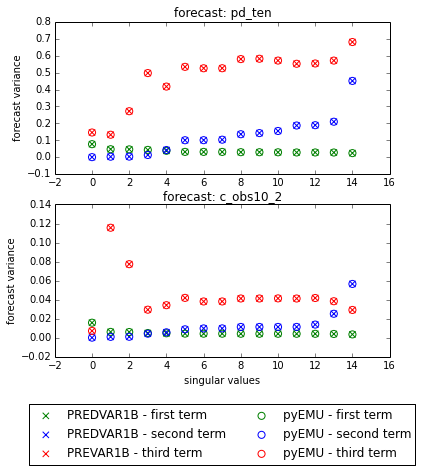

In [14]:
fig = plt.figure(figsize=(6,6))
max_idx = 15
idx = np.arange(max_idx)
for ipred,pred in enumerate(predictions):
    arr = pv1b_results[pred][:max_idx,:]
    first = df[("first", pred)][:max_idx]
    second = df[("second", pred)][:max_idx]
    third = df[("third", pred)][:max_idx]
    ax = plt.subplot(len(predictions),1,ipred+1)
    #ax.plot(arr[:,1],color='b',dashes=(6,6),lw=4,alpha=0.5)
    #ax.plot(first,color='b')
    #ax.plot(arr[:,2],color='g',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(second,color='g')
    #ax.plot(arr[:,3],color='r',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(third,color='r')
    
    ax.scatter(idx,arr[:,1],marker='x',s=40,color='g',
               label="PREDVAR1B - first term")
    ax.scatter(idx,arr[:,2],marker='x',s=40,color='b',
               label="PREDVAR1B - second term")
    ax.scatter(idx,arr[:,3],marker='x',s=40,color='r',
               label="PREVAR1B - third term")
    ax.scatter(idx,first,marker='o',facecolor='none',
               s=50,color='g',label='pyEMU - first term')
   
    ax.scatter(idx,second,marker='o',facecolor='none',
               s=50,color='b',label="pyEMU - second term")
    
    ax.scatter(idx,third,marker='o',facecolor='none',
               s=50,color='r',label="pyEMU - third term")
    ax.set_ylabel("forecast variance")
    ax.set_title("forecast: " + pred)
    if ipred == len(predictions) -1:
        ax.legend(loc="lower center",bbox_to_anchor=(0.5,-0.75),
                  scatterpoints=1,ncol=2)
        ax.set_xlabel("singular values")
    #break
plt.savefig("predvar1b_ver.eps")    
    